In [3]:

import numpy as np
import networkx as nx
import hashlib
G = nx.read_edgelist("large_twitch_edges.csv", delimiter=',')


In [4]:
print(G)

Graph with 168114 nodes and 6797557 edges


In [5]:
def DegreeDiscountHeuristic(seed_num,G, p):
    degree_dict = {}

    for tuple in G.degree():
        degree_dict[tuple[0]] = tuple[1]
    seeds = []
    for i in range(seed_num):
        max_degree = max(degree_dict, key=degree_dict.get)
        seeds.append(max_degree)
        degree_dict.pop(max_degree)
        for node in G.neighbors(max_degree):
            if node in degree_dict:
                degree_dict[node] = degree_dict[node] - 2*(i+1) - ( degree_dict[node] - i - 1)*(i+1)*p
    return seeds
            

In [6]:
def DegreeHeuristic(seed_num,G):
    degree_heuristic = [node for (node, val) in sorted(G.degree(), reverse=True,key=lambda pair: pair[1])]
    seeds = degree_heuristic[0:seed_num]
    return seeds

In [13]:
def LIRHeuristic(seed_num,G):
    degree_dict = {}

    for tuple in G.degree():
        degree_dict[tuple[0]] = tuple[1]
    LIR_0 = []
    for i in range(seed_num):
        for node in degree_dict:
            LIR_value = 0
            for neighbor in G.neighbors(node):
                if degree_dict[node] < degree_dict[neighbor]:
                    LIR_value = LIR_value + 1
                    if LIR_value > i:
                        break
            if LIR_value == i:
                LIR_0.append([node, degree_dict[node], LIR_value])
        if len(LIR_0) >= seed_num:
                break
            
    LIR_heuristic = [(node) for (node, val, lir) in sorted(sorted(LIR_0, reverse=True,key=lambda pair: pair[1]), key=lambda pair: pair[2])]
    return LIR_heuristic[0:seed_num]


In [14]:
def IndependentCascade(G, seeds, p, perm_seed):
    np.random.seed(perm_seed)
    active_nodes = seeds
    spread = []
    while len(active_nodes) > 0:
        curr  = active_nodes[0]
        for  neighbor in G.neighbors(curr):
            if neighbor not in active_nodes and neighbor not in spread:
                if np.random.uniform(0,1) <= p:
                    active_nodes.append(neighbor)
        spread.append(curr)
        active_nodes.remove(active_nodes[0])
    return len(spread)


In [18]:
def propagate_nx(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node)

    return(targets)

In [ ]:
def IC(G,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
                       
            targets = propagate_nx(G,p,new_active)

    
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(int(hashlib.sha256(str(1000+i).encode()).hexdigest(),16)%4294967295)
            success = np.random.uniform(0,1,len(targets)) < p
            new_ones = list(np.extract(success, sorted(targets)))
            
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active = list(set(new_ones) - set(A))
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread),A)

In [22]:
p = 0.003
seeds_DDH = DegreeDiscountHeuristic(10,G,p)
result = IC(G,seeds_DDH,p,100)


In [24]:
result[0]

9439.49

In [ ]:
seed_range = 50
p = 0.01
permutation_num = 1000
DDH_averages = []
Degree_averages = []
LIR_averages = []
for i in range(1,seed_range + 1):
    seeds_DDH = DegreeDiscountHeuristic(i,G,p)
    seeds_Degree = DegreeHeuristic(i,G)
    seeds_LIR = LIRHeuristic(i,G)
    seed_count_DDH = IC(G,seeds_DDH,p,permutation_num)
    seed_count_Degree = IC(G,seeds_DDH,p,permutation_num)
    seed_count_LIR = IC(G,seeds_DDH,p,permutation_num)
    DDH_averages.append(seed_count_DDH[0])
    Degree_averages.append(seed_count_DDH[0])
    LIR_averages.append(seed_count_LIR[0])
print(LIR_averages)

KeyboardInterrupt: 

In [10]:
print(DDH_averages)
print(Degree_averages)
print(LIR_averages)

[0, 9273, 9175, 9385, 9254]
[0, 9273, 9175, 9385, 9254]
[0, 9273, 9352, 9178, 9183]


/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fcaf6f7d050>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fcaf6f7dd10>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fcaf6f7d610>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-pro

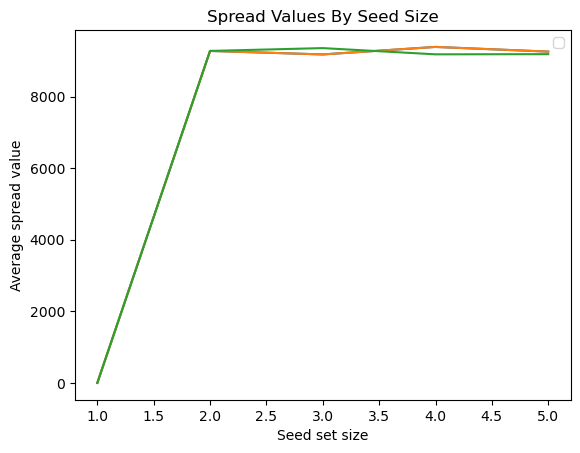

In [12]:
import matplotlib.pyplot as plt

x = range(1, 6)

line1 = plt.plot(x, DDH_averages)
line2 = plt.plot(x, Degree_averages)
line3 = plt.plot(x, LIR_averages)
plt.legend([line1, line2, line3], ['Degree Discount Heuristic', 'Degree Heuristic', 'Local Index Ranking'])
plt.xlabel("Seed set size")
plt.ylabel("Average spread value")
plt.title('Spread Values By Seed Size')

plt.show()